In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, UpSampling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-03-05 03:33:30.918085: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 03:33:30.918205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 03:33:31.235310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data

In [2]:
base_dir = '/kaggle/input/carvana-image-masking-png'
images_dir = f'{base_dir}/train_images' 
masks_dir = f'{base_dir}/train_masks' 

In [3]:
train_image_files = os.listdir(images_dir)
train_mask_files = os.listdir(masks_dir)

In [4]:
len(train_image_files)

5088

# Visualize Training Data

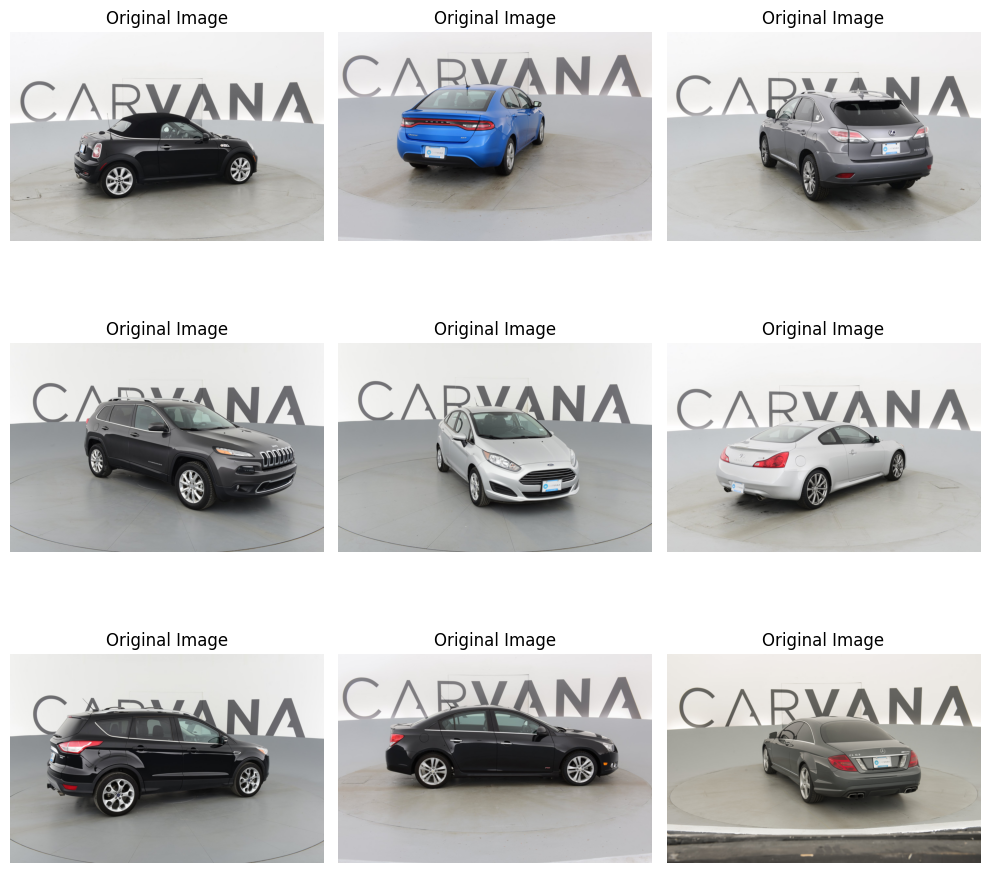

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # Load the image
    image = cv2.imread(os.path.join(images_dir, train_image_files[i]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.set_title('Original Image')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Visualizing Ground Truth Masks

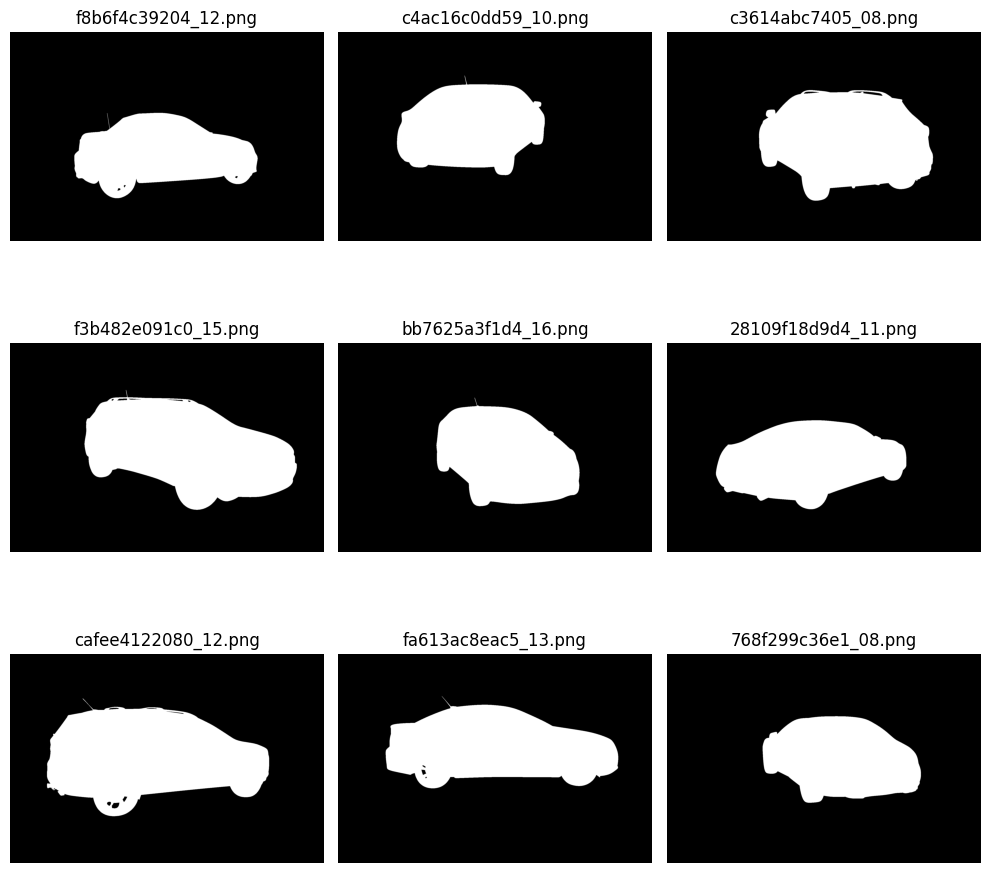

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    mask_filenames = train_image_files[i][0:-4]+'.png'
    mask = cv2.imread(os.path.join(masks_dir, mask_filenames), cv2.IMREAD_GRAYSCALE)
    mask = (mask > 0).astype(np.uint8) * 255
    ax.imshow(mask, cmap='gray')
    ax.set_title(mask_filenames)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
images = []
masks = []


for image_file in train_image_files[0:501]:
    image = cv2.imread(os.path.join(images_dir, image_file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

    mask_file = train_image_files[i][0:-4]+'.png'
    mask = cv2.imread(os.path.join(masks_dir, mask_file), cv2.IMREAD_GRAYSCALE)
    mask = (mask > 0).astype(np.uint8)  # Convert mask to binary (0 or 1)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

In [8]:
print(images.shape)

(501, 1280, 1918, 3)


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
resized_images = []
resized_masks = []


image_size = (128, 128)
for image, mask in zip(images, masks):
    resized_image = cv2.resize(image, image_size)
    resized_mask = cv2.resize(mask, image_size)

    resized_images.append(resized_image)
    resized_masks.append(resized_mask)

resized_images = np.array(resized_images)
resized_masks = np.array(resized_masks)

# Splitting Data

In [11]:
X_train, X_val, y_train, y_val = train_test_split(resized_images, resized_masks, test_size=0.2, random_state=42)


X_train = X_train / 255.0
X_val = X_val / 255.0


y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

X_train.sort()
X_val.sort()
y_train.sort()
y_val.sort()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (400, 128, 128, 3)
y_train shape: (400, 128, 128, 1)
X_val shape: (101, 128, 128, 3)
y_val shape: (101, 128, 128, 1)


# U-Net Architecture

In [12]:
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Middle
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Decoder
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    concat6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    concat7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    concat8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    concat9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [13]:
input_shape = (128, 128, 3)

model = unet_model(input_shape)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 31,039,681 (118.41 MB)

 Trainable params: 31,035,713 (118.39 MB)

 Non-trainable params: 3,968 (15.50 KB)

# Data Augmentation

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator()

In [57]:
train_generator = train_datagen.flow(
    X_train, 
    y_train, 
    batch_size=16)

# Create validation generator
val_generator = val_datagen.flow(
    X_val, 
    y_val, 
    batch_size=16)

In [58]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [59]:
callbacks = [
    EarlyStopping(patience=5, monitor = 'val_loss'),
    ReduceLROnPlateau(factor=0.1, patience=3, monitor = 'val_loss'),
]

In [60]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks = callbacks
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 331ms/step - accuracy: 0.7350 - loss: 9.8221 - val_accuracy: 0.8667 - val_loss: 0.5641 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.9509 - loss: 0.1248 - val_accuracy: 0.8892 - val_loss: 1.2506 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.9802 - loss: 0.0476 - val_accuracy: 0.9288 - val_loss: 0.3962 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - accuracy: 0.9894 - loss: 0.0248 - val_accuracy: 0.9350 - val_loss: 0.2366 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.9927 - loss: 0.0171 - val_accuracy: 0.9582 - val_loss: 0.1346 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.9938 - loss: 0.0140 - val_accuracy: 0.9744 - val_loss: 0.0859 - learning_rate: 0.0010
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.9948 - loss: 0.0117 

In [64]:
model.save('unet_custom_99%.keras')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


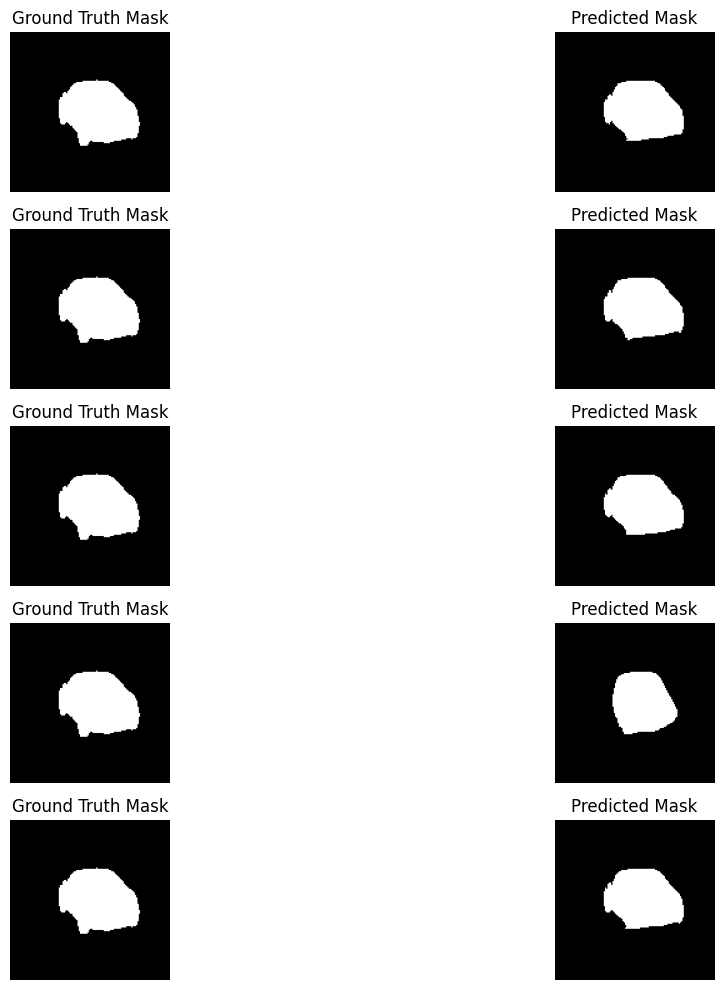

In [81]:
model.load_weights('/kaggle/working/unet_custom_99%.keras')

predicted_masks = model.predict(X_val)

# Visualize original images, predicted masks, and ground truth masks
fig, axes = plt.subplots(5, 2, figsize=(15, 10))

for i, ax_row in enumerate(axes):

    # Ground Truth Mask
    mask_gt = y_test[i].squeeze()
    ax_row[0].imshow(mask_gt, cmap='gray')
    ax_row[0].set_title('Ground Truth Mask')
    ax_row[0].axis('off')
    
    # Predicted Mask
    predicted_mask = predicted_masks[i]
    predicted_mask = (predicted_mask>0.5).astype(np.uint8) * 255
    ax_row[1].imshow(predicted_mask, cmap='gray')
    ax_row[1].set_title('Predicted Mask')
    ax_row[1].axis('off')

plt.tight_layout()
plt.show()